Problem 1 

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [9]:
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=64, shuffle=True)

testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = DataLoader(testset, batch_size=64, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [10]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(32*32*3, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, 10)
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)
        
    def forward(self, x):
        x = x.view(-1, 32*32*3)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.softmax(self.fc3(x))
        return x

In [29]:
model = MLP().to(device)
critertion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001)

In [30]:
num_epochs = 20
train_loss = []
train_acc = []
val_acc = []
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        
        outputs = model(inputs)
        loss = critertion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted==labels).sum().item()
        
    train_loss.append(running_loss/len(trainloader))
    train_acc.append(100*correct/total)

In [31]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        
        total += labels.size(0)
        correct += (predicted==labels).sum().item()
    val_acc.append(100*correct/total)

In [32]:
y_pred = []
y_true = []
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        
        y_pred.extend(predicted.cpu().numpy())
        y_true.extend(labels.cpu().numpy())

In [33]:
precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')
conf_mat = confusion_matrix(y_true, y_pred)
print('Precision: {:.4f}'.format(precision))
print('Recall: {:.4f}'.format(recall))
print('F1: {:.4f}'.format(f1))
print('Confusion Matrix: \n', conf_mat)


Precision: 0.0684
Recall: 0.0809
F1: 0.0400
Confusion Matrix: 
 [[262 698   0  11   0   6   0   1   0   0   1  12   3   5   0   1]
 [ 25 957   0   5   0   3   0   3   0   0   0   0   0   4   0   3]
 [ 94 865   0   4   0  16   0   3   0   0   0   6   2   3   0   7]
 [ 63 843   0  26   0  33   0   2   0   0   0  10   1   7   0  15]
 [ 30 887   0  17   0  44   0   6   0   0   0   6   2   1   0   7]
 [ 62 822   0  29   0  43   0  10   0   0   0  10   0   9   0  15]
 [ 26 934   0   2   0  24   0   4   0   0   0   2   0   3   0   5]
 [ 31 904   0  20   0  17   0   7   0   0   0   6   2   5   0   8]
 [ 56 896   0  16   0   4   0   0   0   0   0   4   1  18   1   4]
 [ 24 961   0   4   0   4   0   3   0   0   0   0   0   2   0   2]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0

C:\Users\SirM\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\SirM\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


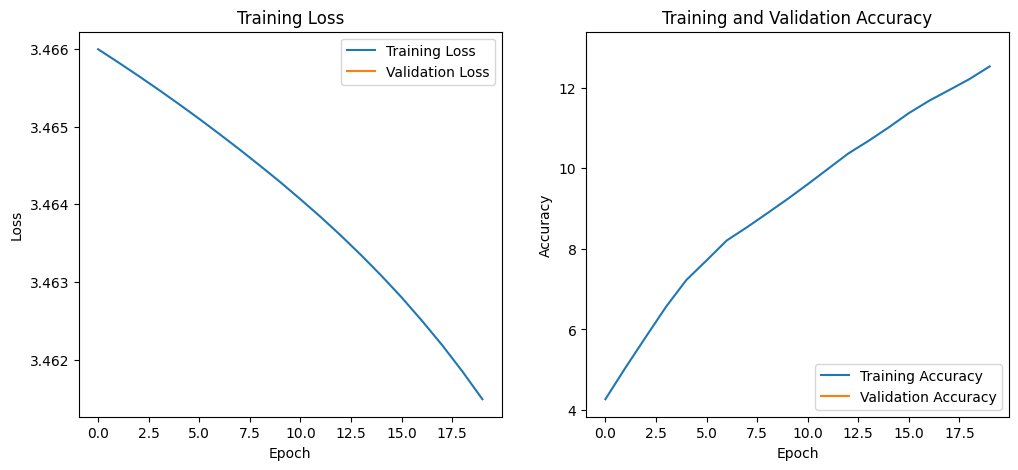

In [34]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()